This notebook shows a simple workflow to render audio-reactive latent interpolations as described in [this paper](https://wavefunk.xyz/assets/audio-reactive-stylegan/paper.pdf) for the NeurIPS 2020 [Workshop on Machine Learning for Creativity & Design](https://neurips2020creativity.github.io/).

A very basic, WIP notebook to choose latent vectors for the interpolations can be found [here](https://colab.research.google.com/drive/1BJ3wk_SkCftjLF2jJXOt0OsiETy1F1bz) (for now it's only verified to work for Linux, as it requires forwarding X11 to an SSH session from your local machine).

You can find a slightly simpler description of the paper's main contributions in this [blog post](https://wavefunk.xyz/audio-reactive-stylegan).

# Preparation

In [ ]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/monixypAI /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/monixypAI': File exists
/content/gdrive/My Drive/Colab Notebooks/monixypAI


Upload an audio file

In [ ]:
from google.colab import files
uploaded = files.upload()
audio_file = list(uploaded.keys())[0]
print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

Saving Jai Paul - BTSTU.mp3 to Jai Paul - BTSTU.mp3
User uploaded file "Jai Paul - BTSTU.mp3" with length 8525025 bytes


Download all the required dependencies

In [ ]:
!nvidia-smi --query-gpu=name,memory.free --format=csv,noheader
!echo
%tensorflow_version 1.x
# !git clone https://github.com/NVlabs/stylegan2.git
# !git clone https://github.com/NVlabs/stylegan2-ada.git
# !git clone https://github.com/rosinality/stylegan2-pytorch
# !git clone https://github.com/JCBrouwer/maua-stylegan2
!mv "$audio_file" maua-stylegan2/
%cd /mydrive/maua-stylegan2
!pip install librosa madmom kornia Ninja matplotlib scikit-image gdown
%matplotlib inline
!wget https://github.com/kkroening/ffmpeg-python/archive/0.2.0.zip
!unzip 0.2.0.zip
!mv ffmpeg-python-0.2.0/ffmpeg ./
!rm -rf ffmpeg-python-0.2.0/ 0.2.0.zip

Tesla K80, 11441 MiB

TensorFlow 1.x selected.
/content/gdrive/My Drive/Colab Notebooks/monixypAI/maua-stylegan2
--2021-04-05 15:40:26--  https://github.com/kkroening/ffmpeg-python/archive/0.2.0.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kkroening/ffmpeg-python/zip/0.2.0 [following]
--2021-04-05 15:40:26--  https://codeload.github.com/kkroening/ffmpeg-python/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 52.68.31.213
Connecting to codeload.github.com (codeload.github.com)|52.68.31.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [  <=>               ]   3.13M  11.1MB/s    in 0.3s    

2021-04-05 15:40:27 (11.1 MB/s) - ‘0.2.0.zip’ saved [3283202]

Archive:  0.2.0.zip
78fb6cf2f11cb93c6071c978a92a640

Download a stylegan network checkpoint (alternatively upload your own, drag and drop to files menu on left).

good places to find networks:

https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/

https://github.com/justinpinkney/awesome-pretrained-stylegan2

In [ ]:
# FFHQ
# !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl

# Derrick Schultz's Frea Buckler network (from awesome-pretrained-stylegan2)
# !gdown https://drive.google.com/u/0/uc?id=1YzZemZAp7BVW701_BZ7uabJWJJaS2g7v

Convert tensorflow .pkl checkpoint to pytorch .pt checkpoint

`--repo` argument must coincide with the repository that the .pkl was trained with

In [ ]:
# !python ../stylegan2-pytorch/convert_weight.py --gen ffhq.pkl --repo ../stylegan2-ada/
# !python ../stylegan2-pytorch/convert_weight.py --gen FreaGAN.pkl --repo ../stylegan2/

# !python ../stylegan2-pytorch/convert_weight.py --gen monixyp.pkl --repo /mydrive/stylegan2-ada

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
tensor(0.0053, device='cuda:0')
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


# Audio-reactive

This is where the functions that make the video react to the music are defined.

You can find more examples of these functions [here](https://github.com/JCBrouwer/maua-stylegan2/tree/master/audioreactive/examples)


First initialize things that will be resused multiple times

n.b. get_noise() will be called >10 times for different sizes, so preparing things beforehand can save a lot of *time*

In [ ]:
import torch as th
import librosa as rosa
import audioreactive as ar

def initialize(args):
    # exercise for the reader:
    # install https://github.com/deezer/spleeter
    # split your audio file into 4 tracks
    # then load them individually for higher-quality onsets/chroma/etc. e.g.:
    #     !spleeter separate $audio_file -p spleeter:4stems
    #     drums, drum_sr = rosa.load("/path/to/drum_file.wav")

    args.lo_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmax=150, smooth=3)
    args.hi_onsets = ar.onsets(args.audio, args.sr, args.n_frames, fmin=150, smooth=3)

    print("onsets:")
    ar.plot_signals([args.hi_onsets, args.lo_onsets])

    return args

Create audioreactive latents default shape for 1024px network is: [n_frames, 18, 512]

In [ ]:
def get_latents(selection, args):
    chroma = ar.chroma(args.audio, args.sr, args.n_frames)

    print("chroma:")
    ar.plot_spectra([chroma], chroma=True)

    chroma_latents = ar.chroma_weight_latents(chroma, selection)
    latents = ar.gaussian_filter(chroma_latents, 4)

    lo_onsets = args.lo_onsets[:, None, None]
    hi_onsets = args.hi_onsets[:, None, None]

    latents = hi_onsets * selection[[-4]] + (1 - hi_onsets) * latents
    latents = lo_onsets * selection[[-7]] + (1 - lo_onsets) * latents

    latents = ar.gaussian_filter(latents, 2, causal=0.2)

    return latents

Create audioreactive noise

In [ ]:
def get_noise(height, width, scale, num_scales, args):
    if width > 256:
        return None

    lo_onsets = args.lo_onsets[:, None, None, None].cuda()
    hi_onsets = args.hi_onsets[:, None, None, None].cuda()

    noise_noisy = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 5)
    noise = ar.gaussian_filter(th.randn((args.n_frames, 1, height, width), device="cuda"), 128)

    if width < 128:
        noise = lo_onsets * noise_noisy + (1 - lo_onsets) * noise
    if width > 32:
        noise = hi_onsets * noise_noisy + (1 - hi_onsets) * noise

    noise /= noise.std() * 2.5

    return noise.cpu()

Create audioreactive network bends (here the width is doubled for 1920x1080 output).

In [ ]:
def get_bends(args):
    transform = th.nn.Sequential(
        th.nn.ReplicationPad2d((2, 2, 0, 0)), ar.AddNoise(0.025 * th.randn(size=(1, 1, 4, 8), device="cuda")),
    )
    return [{"layer": 0, "transform": transform}]

Try to empty GPU memory each time you run generate()

Sometimes it doesn't get cleared completely

In [ ]:
print("Time                     GPU        Used      Total")
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader

Time                     GPU        Used      Total
2021/04/05 15:40:33.222, Tesla K80, 3 MiB, 11438 MiB
2021/04/05 15:40:33.460, Tesla K80, 3 MiB, 11438 MiB


Render the final video!

onsets:


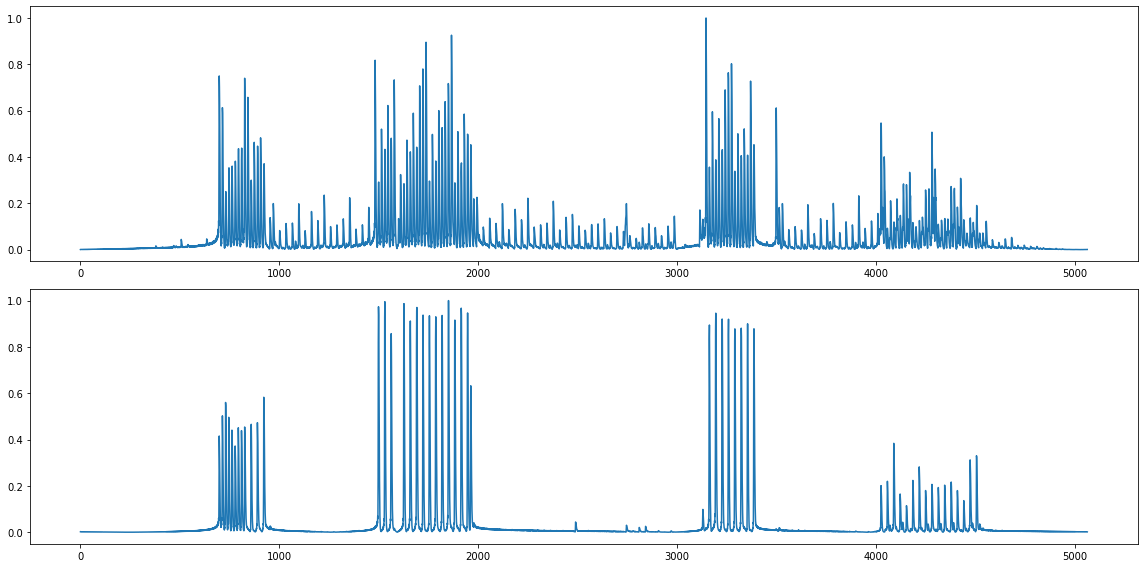


generating latents...
chroma:


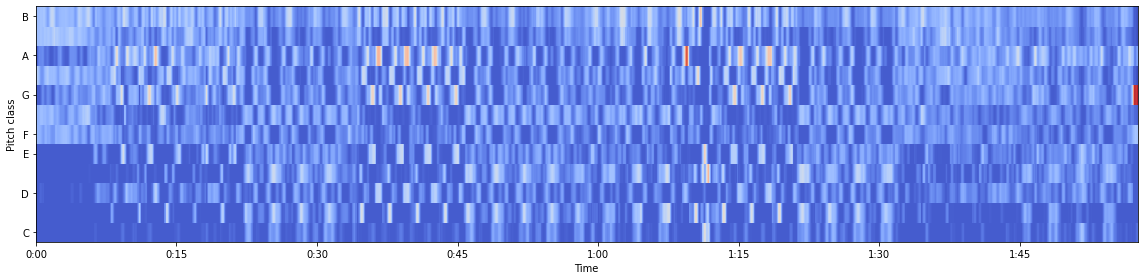

[5064, 18, 512] amplitude=0.26372289657592773

generating noise...
[5064, 1, 4, 8] amplitude=0.4000000059604645
[5064, 1, 8, 16] amplitude=0.4000000059604645
[5064, 1, 8, 16] amplitude=0.40000003576278687
[5064, 1, 16, 32] amplitude=0.3999999761581421
[5064, 1, 16, 32] amplitude=0.4000000059604645
[5064, 1, 32, 64] amplitude=0.4000000059604645
[5064, 1, 32, 64] amplitude=0.4000000059604645
[5064, 1, 64, 128] amplitude=0.40000003576278687
[5064, 1, 64, 128] amplitude=0.4000000059604645
[5064, 1, 128, 256] amplitude=0.4000000059604645
[5064, 1, 128, 256] amplitude=0.40000003576278687

generating network bends...

preprocessing took 105.10s

rendering 5064 frames...


100%|███████████████████████████████████████| 5064/5064 [27:15<00:00,  3.10it/s]



total time taken: 29.33 minutes


In [ ]:
from generate_audiovisual import generate
# you want to set the batch size and ffmpeg_preset as large and as slow as your GPU can handle
# larger batches => faster, slower preset => smaller + better quality video files
generate(
  ckpt="monixyp.pt",
  audio_file=audio_file,
  output_dir="../",
  out_size=1920, # at the moment only 512x512, 1024x1024, 1920x1080 outputs are supported (out_size = 512, 1024, or 1920 respectively)
  G_res=1024,
  batch=1,  # CUDA out of memory errors => smaller batch (also try running the previous cell, to clear some GPU memory)
  ffmpeg_preset="faster",  # RAM crashes => faster preset (see https://trac.ffmpeg.org/wiki/Encode/H.264)
  fps=24,
  duration=211, # remove this line for full video
  initialize=initialize,
  get_latents=get_latents,
  get_noise=get_noise,
  get_bends=get_bends, # if you're running a 1024px network you can uncomment this for 1920x1080 output
)

You can now upload a new audio file using the following cell and then render it by only executing the previous cell.

In [ ]:
# from google.colab import files
# uploaded = files.upload()
# audio_file = list(uploaded.keys())[0]
# print('User uploaded file "{name}" with length {length} bytes'.format(name=audio_file, length=len(uploaded[audio_file])))

P.S.

To load seeds from NVIDIA's official stylegan repositories (or forks thereof):

In [ ]:
# import numpy as np

# seed = 1000
# nvlatent = np.random.RandomState(seed).randn(1, 512) # shape = [1, 512]
# latent1 = np.stack([nvlatents]*18, axis=1) # shape = [1, 18, 512]
# # repeat for some more seeds
# # ...
# latents = np.concatenate([latent1, latent2, ..., latent11], axis=0) # shape = [12, 18, 512]

# np.save(latents, "my_latents.npy")

This assumes a default 1024x1024 network (18 layers) with a latent dimension of 512. You'll need to adjust some numbers above if your network has a different resolution or latent_dim.

Now `my_latents.npy` can be loaded to `generate()` as an argument `latent_file="my_latents.npy"`

In [ ]:
# weights = './monixyp.pt'
# dir = './'
# !python select_latents.py \
#         --ckpt=$weights \
#         --output_dir=$dir

Traceback (most recent call last):
  File "select_latents.py", line 289, in <module>
    root = tk.Tk()
  File "/usr/lib/python3.7/tkinter/__init__.py", line 2023, in __init__
    self.tk = _tkinter.create(screenName, baseName, className, interactive, wantobjects, useTk, sync, use)
_tkinter.TclError: no display name and no $DISPLAY environment variable
